### **Notepad for Dissertation TL Fine tuning with low learning rate for six pretrained models using NSL-KDD Datasets**
###for images with resolution 224 x 224


# NSL-KDD Dataset preparation using text to image conversion

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
train = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTrain%2B.txt'
test = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTest%2B.txt'
test21 = 'https://raw.githubusercontent.com/sepahpourka/NSL-KDD-Datasets/main/KDDTest-21.txt'

In [ ]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

In [ ]:
#train_data = pd.read_csv(train,names=feature)
test_data = pd.read_csv(test,names=feature)
#data = pd.concat([train_data, test_data], ignore_index=True)
data = pd.concat([test_data], ignore_index=True)

data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


In [ ]:
# Redistribute across common attack class
# Type of attacks: DoS (Denial of Service attacks), R2L (Root to Local attacks), U2R (User to Root attack) and Probe (Probing attacks).
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'abnormal',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'abnormal',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'abnormal',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'abnormal',inplace=True)

change_label(data)

In [ ]:
# distribution of attack classes
data.label.value_counts()

abnormal    12833
normal       9711
Name: label, dtype: int64

In [ ]:
label = pd.DataFrame(data.label)


# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
from sklearn import preprocessing
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data

(22544, 44)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty,intrusion
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,abnormal,21,0
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,abnormal,21,0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,1
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,abnormal,15,0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,abnormal,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,1
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,1
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,abnormal,15,0
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21,1


In [ ]:
df = pd.DataFrame(data)

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty,intrusion
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,abnormal,21,0
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,abnormal,21,0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,1
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,abnormal,15,0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,abnormal,11,0


In [ ]:
df['information'] = df['duration'].astype(str) + " "+ df['protocol_type'].astype(str) + " "+ df['service'].astype(str) + " "+ df['flag'].astype(str) + " "+ df['src_bytes'].astype(str) + " "+ df['dst_bytes'].astype(str) + " "+ df['land'].astype(str) + " "+ df['wrong_fragment'].astype(str) + " "+ df['urgent'].astype(str) + " "+ df['hot'].astype(str) + " "+ df['num_failed_logins'].astype(str) + " "+ df['logged_in'].astype(str) + " "+ df['num_compromised'].astype(str) + " "+ df['root_shell'].astype(str) + " "+ df['su_attempted'].astype(str) + " "+ df['num_root'].astype(str) + " "+ df['num_file_creations'].astype(str) + " "+ df['num_shells'].astype(str) + " "+ df['num_access_files'].astype(str) + " "+ df['num_outbound_cmds'].astype(str) + " "+ df['is_host_login'].astype(str) + " "+ df['is_guest_login'].astype(str) + " "+ df['count'].astype(str) + " "+ df['srv_count'].astype(str) + " "+ df['serror_rate'].astype(str) + " "+ df['srv_serror_rate'].astype(str) + " "+ df['rerror_rate'].astype(str) + " "+ df['srv_rerror_rate'].astype(str) + " "+ df['same_srv_rate'].astype(str) + " "+ df['diff_srv_rate'].astype(str) + " "+ df['srv_diff_host_rate'].astype(str) + " "+ df['dst_host_count'].astype(str) + " "+ df['dst_host_srv_count'].astype(str) + " "+ df['dst_host_same_srv_rate'].astype(str) + " "+ df['dst_host_diff_srv_rate'].astype(str) + " "+ df['dst_host_same_src_port_rate'].astype(str) + " "+ df['dst_host_srv_diff_host_rate'].astype(str) + " "+ df['dst_host_serror_rate'].astype(str) + " "+ df['dst_host_srv_serror_rate'].astype(str) + " "+ df['dst_host_rerror_rate'].astype(str) + " "+ df['dst_host_srv_rerror_rate'].astype(str)


# remove attribute 'difficulty_level'
df.drop(['duration'],axis=1,inplace=True)
df.drop(['protocol_type'],axis=1,inplace=True)
df.drop(['service'],axis=1,inplace=True)
df.drop(['flag'],axis=1,inplace=True)
df.drop(['src_bytes'],axis=1,inplace=True)
df.drop(['dst_bytes'],axis=1,inplace=True)
df.drop(['land'],axis=1,inplace=True)
df.drop(['wrong_fragment'],axis=1,inplace=True)
df.drop(['urgent'],axis=1,inplace=True)
df.drop(['hot'],axis=1,inplace=True)
df.drop(['num_failed_logins'],axis=1,inplace=True)
df.drop(['logged_in'],axis=1,inplace=True)
df.drop(['num_compromised'],axis=1,inplace=True)
df.drop(['root_shell'],axis=1,inplace=True)
df.drop(['su_attempted'],axis=1,inplace=True)
df.drop(['num_root'],axis=1,inplace=True)
df.drop(['num_file_creations'],axis=1,inplace=True)
df.drop(['num_shells'],axis=1,inplace=True)
df.drop(['num_access_files'],axis=1,inplace=True)
df.drop(['num_outbound_cmds'],axis=1,inplace=True)
df.drop(['is_host_login'],axis=1,inplace=True)
df.drop(['is_guest_login'],axis=1,inplace=True)
df.drop(['count'],axis=1,inplace=True)
df.drop(['srv_count'],axis=1,inplace=True)
df.drop(['serror_rate'],axis=1,inplace=True)
df.drop(['srv_serror_rate'],axis=1,inplace=True)
df.drop(['rerror_rate'],axis=1,inplace=True)
df.drop(['srv_rerror_rate'],axis=1,inplace=True)
df.drop(['same_srv_rate'],axis=1,inplace=True)
df.drop(['diff_srv_rate'],axis=1,inplace=True)
df.drop(['srv_diff_host_rate'],axis=1,inplace=True)
df.drop(['dst_host_count'],axis=1,inplace=True)
df.drop(['dst_host_srv_count'],axis=1,inplace=True)
df.drop(['dst_host_same_srv_rate'],axis=1,inplace=True)
df.drop(['dst_host_diff_srv_rate'],axis=1,inplace=True)
df.drop(['dst_host_same_src_port_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_diff_host_rate'],axis=1,inplace=True)
df.drop(['dst_host_serror_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_serror_rate'],axis=1,inplace=True)
df.drop(['dst_host_rerror_rate'],axis=1,inplace=True)
df.drop(['dst_host_srv_rerror_rate'],axis=1,inplace=True)
df.drop(['difficulty'],axis=1,inplace=True)

df.head()

,label,intrusion,information
0,abnormal,0,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,abnormal,0,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,normal,1,2 tcp ftp_data SF 12983 0 0 0 0 0 0 0 0 0 0 0 ...
3,abnormal,0,0 icmp eco_i SF 20 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,abnormal,0,1 tcp telnet RSTO 0 15 0 0 0 0 0 0 0 0 0 0 0 0...


In [ ]:
df

,label,intrusion,information
0,abnormal,0,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,abnormal,0,0 tcp private REJ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,normal,1,2 tcp ftp_data SF 12983 0 0 0 0 0 0 0 0 0 0 0 ...
3,abnormal,0,0 icmp eco_i SF 20 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,abnormal,0,1 tcp telnet RSTO 0 15 0 0 0 0 0 0 0 0 0 0 0 0...
...,...,...,...
22539,normal,1,0 tcp smtp SF 794 333 0 0 0 0 0 1 0 0 0 0 0 0 ...
22540,normal,1,0 tcp http SF 317 938 0 0 0 0 0 1 0 0 0 0 0 0 ...
22541,abnormal,0,0 tcp http SF 54540 8314 0 0 0 2 0 1 1 0 0 0 0...
22542,normal,1,0 udp domain_u SF 42 42 0 0 0 0 0 0 0 0 0 0 0 ...


In [ ]:
df.shape

(22544, 3)

In [ ]:
!pip3 install text_to_image

In [ ]:
# importing os module
import os
import shutil

# path
images_path = '/content/images'
if os.path.isdir(images_path):
  shutil.rmtree(images_path)
else:
   print("Given directory doesn't exist")


In [ ]:
# path
images_path = '/content/images'
normal_path = '/content/images/normal'
abnormal_path = '/content/images/abnormal'

try:
    os.mkdir(images_path)
    os.mkdir(normal_path)
    os.mkdir(abnormal_path)
except OSError as error:
    print(error)

In [ ]:
import text_to_image

for index in df.index:
  filename = "/content/images/" + df.loc[index,'label'] + "/" + "image_" + str(index) +".png"
  df.loc[index,'information'] = text_to_image.encode(df.loc[index,'information'], filename)


In [ ]:
import pathlib
data_dir = "/content/images"
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

22544


In [ ]:
import PIL

normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))

In [ ]:
abnormal = list(data_dir.glob('abnormal/*'))
PIL.Image.open(str(abnormal[1]))

In [ ]:
print(df.loc[0,'information'])

/content/images/abnormal/image_0.png


In [ ]:
from PIL import Image
# iterate over files in
# that directory
for filename in os.listdir('/content/images/normal'):
    image = Image.open("/content/images/normal/" + filename)
    new_image = image.resize((224, 224))
    new_image.save("/content/images/normal/" + filename)
for filename in os.listdir('/content/images/abnormal'):
    image = Image.open("/content/images/abnormal/" + filename)
    new_image = image.resize((224, 224))
    new_image.save("/content/images/abnormal/" + filename)

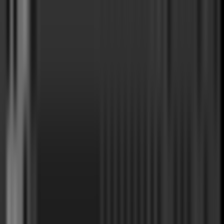

In [ ]:
Probe = list(data_dir.glob('abnormal/*'))
PIL.Image.open(str(Probe[1]))

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_file = '/content/images'
output_files = '/content/split_images'

In [ ]:
splitfolders.ratio(input_file,output=output_files, seed=38, ratio=(0.80, 0.20), group_prefix=None)

Copying files: 22544 files [00:02, 7725.30 files/s]


In [ ]:
input_file = '/content/split_images/train'
output_files = '/content/split_images/split_again/'

In [ ]:
splitfolders.ratio(input_file,output=output_files, seed=38, ratio=(0.75, 0.25), group_prefix=None)

Copying files: 18034 files [00:02, 8193.71 files/s]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

print("Generating Training Data")
train_generator = data_generator.flow_from_directory(
    '/content/split_images/split_again/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    shuffle=True,
    seed=123,
    class_mode='binary')
print(train_generator.class_indices)
x_train, y_train = next(train_generator)

print("Generating Validation Data")
validation_generator = data_generator.flow_from_directory(
    '/content/split_images/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    shuffle=True,
    seed=123,
    class_mode='binary')
print(validation_generator.class_indices)
x_val, y_val = next(validation_generator)

print("Generating Testing Data")
test_generator = data_generator.flow_from_directory(
    '/content/split_images/split_again/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123,
    class_mode='binary')
print(test_generator.class_indices)
x_test, y_test = next(test_generator)

Generating Training Data
Found 10821 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}
Generating Validation Data
Found 901 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}
Generating Testing Data
Found 4509 images belonging to 2 classes.
{'abnormal': 0, 'normal': 1}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/split_again/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(train_ds.class_names)

Found 13525 files belonging to 2 classes.
Using 10820 files for training.
['abnormal', 'normal']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/val',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(val_ds.class_names)

Found 4510 files belonging to 2 classes.
Using 902 files for validation.
['abnormal', 'normal']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/split_images/split_again/val',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(test_ds.class_names)

Found 4509 files belonging to 2 classes.
['abnormal', 'normal']


In [ ]:
class_names = train_ds.class_names
print(class_names)

['abnormal', 'normal']


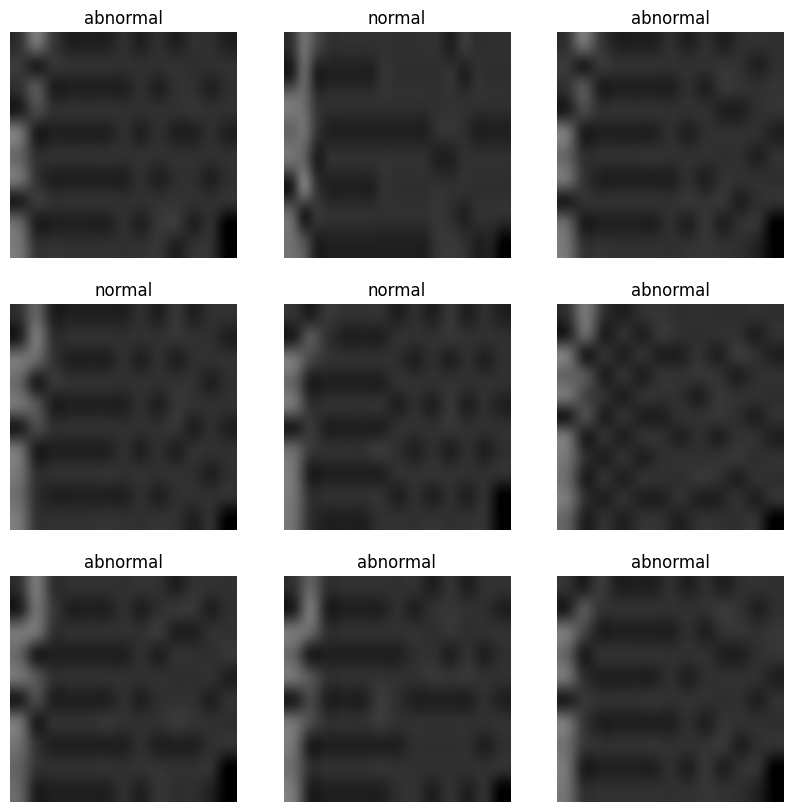

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.5058824


# Transfer Learning using Imagenet classification with ResNet V2 50.

In [ ]:
epochs=10
batchsize=10

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

hub_layer = hub.KerasLayer('https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5', trainable=True, arguments=dict(batch_norm_momentum=0.997))

tmodel = Sequential()
tmodel.add(hub_layer)

# add two hidden layers for classification
tmodel.add(Dense(512, activation='relu'))
tmodel.add(Dense(256, activation='relu'))

# add the prediction layer
tmodel.add(Dense(1, activation=('sigmoid')))

tmodel.build([None, 224, 224, 3])  # Batch input shape.

tmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26260458 (100.18 MB)
Trainable params: 26215018 (100.00 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
import keras

tmodel.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = tmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 142s 306ms/step - loss: 0.5084 - binary_accuracy: 0.9360 - val_loss: 1.0868 - val_binary_accuracy: 0.5732
Epoch 2/10
339/339 [==============================] - 101s 297ms/step - loss: 0.3761 - binary_accuracy: 0.9849 - val_loss: 0.5614 - val_binary_accuracy: 0.9091
Epoch 3/10
339/339 [==============================] - 101s 297ms/step - loss: 0.3519 - binary_accuracy: 0.9932 - val_loss: 0.4089 - val_binary_accuracy: 0.9778
Epoch 4/10
339/339 [==============================] - 101s 298ms/step - loss: 0.3443 - binary_accuracy: 0.9958 - val_loss: 0.3904 - val_binary_accuracy: 0.9789
Epoch 5/10
339/339 [==============================] - 101s 297ms/step - loss: 0.3405 - binary_accuracy: 0.9970 - val_loss: 0.3928 - val_binary_accuracy: 0.9812
Epoch 6/10
339/339 [==============================] - 101s 297ms/step - loss: 0.3402 - binary_accuracy: 0.9968 - val_loss: 0.3891 - val_binary_accuracy: 0.9823
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
tmodel.save("MODEL1-TL-NSL-KDD.keras")

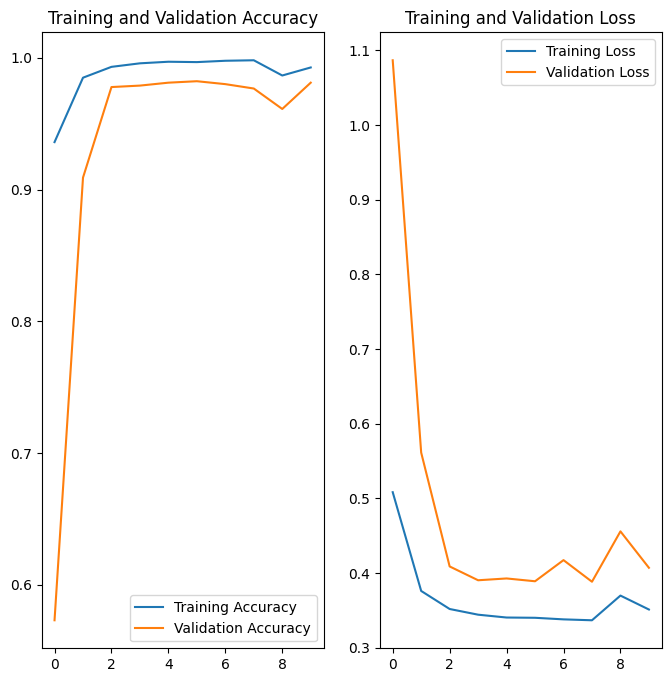

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
score = tmodel.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 2s 82ms/step - loss: 0.4071 - binary_accuracy: 0.9812
Test loss: 0.40713492035865784
Test accuracy: 0.9811530113220215


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# to get predictions for all test data points
Y_pred_res = tmodel.predict(test_generator)

141/141 [==============================] - 14s 90ms/step


[[2531   36]
 [  95 1847]]


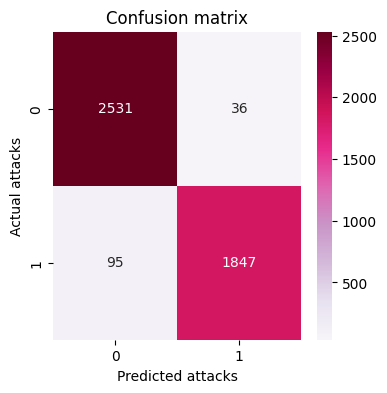

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd',  fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2531   36]
 [  95 1847]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.97      2567
      normal       0.98      0.95      0.97      1942

    accuracy                           0.97      4509
   macro avg       0.97      0.97      0.97      4509
weighted avg       0.97      0.97      0.97      4509



# Transfer Learning using Imagenet classification with ResNet 50

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

hub_layer1 = hub.KerasLayer('https://tfhub.dev/tensorflow/resnet_50/classification/1', trainable=True)

vmodel = Sequential()
vmodel.add(hub_layer1)

# add two hidden layers for classification
vmodel.add(Dense(512, activation='relu'))
vmodel.add(Dense(256, activation='relu'))

# add the prediction layer
vmodel.add(Dense(1, activation=('sigmoid')))

vmodel.build([None, 224, 224, 3])  # Batch input shape.

vmodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              25612201  
                                                                 
 dense_26 (Dense)            (None, 512)               513024    
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 26256810 (100.16 MB)
Trainable params: 26203690 (99.96 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
vmodel.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = vmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 144s 343ms/step - loss: 1.0725 - binary_accuracy: 0.9074 - val_loss: 1.0111 - val_binary_accuracy: 0.9412
Epoch 2/10
339/339 [==============================] - 114s 337ms/step - loss: 0.9226 - binary_accuracy: 0.9595 - val_loss: 0.9505 - val_binary_accuracy: 0.9069
Epoch 3/10
339/339 [==============================] - 114s 336ms/step - loss: 0.7843 - binary_accuracy: 0.9668 - val_loss: 0.8497 - val_binary_accuracy: 0.8747
Epoch 4/10
339/339 [==============================] - 114s 336ms/step - loss: 0.6539 - binary_accuracy: 0.9733 - val_loss: 0.6403 - val_binary_accuracy: 0.9479
Epoch 5/10
339/339 [==============================] - 114s 336ms/step - loss: 0.5672 - binary_accuracy: 0.9728 - val_loss: 0.5497 - val_binary_accuracy: 0.9634
Epoch 6/10
339/339 [==============================] - 114s 336ms/step - loss: 0.5024 - binary_accuracy: 0.9759 - val_loss: 0.4875 - val_binary_accuracy: 0.9734
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
vmodel.save("MODEL2-TL-NSL-KDD.keras")

In [ ]:
score = vmodel.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 3s 98ms/step - loss: 0.4336 - binary_accuracy: 0.9723
Test loss: 0.43355515599250793
Test accuracy: 0.9722838401794434


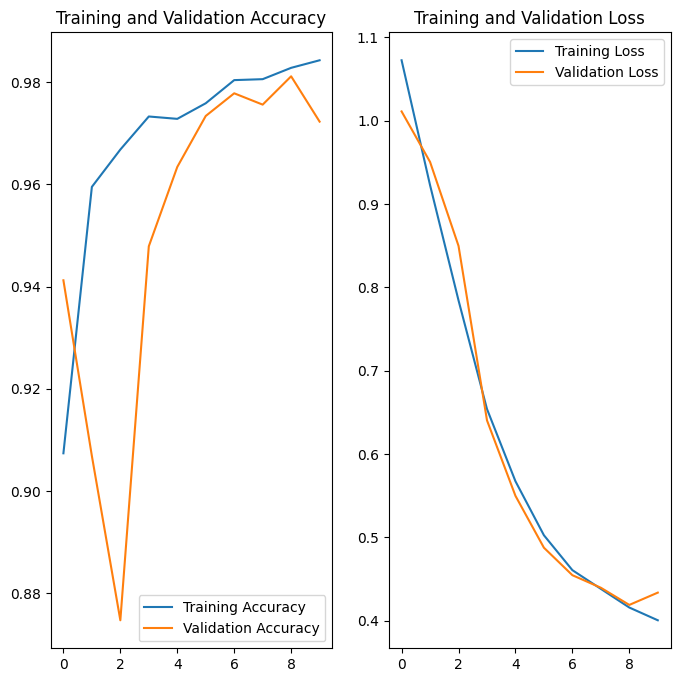

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = vmodel.predict(test_generator)

141/141 [==============================] - 15s 101ms/step


[[2464  103]
 [  49 1893]]


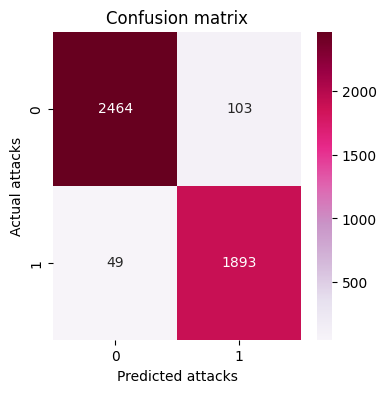

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2464  103]
 [  49 1893]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.98      0.96      0.97      2567
      normal       0.95      0.97      0.96      1942

    accuracy                           0.97      4509
   macro avg       0.96      0.97      0.97      4509
weighted avg       0.97      0.97      0.97      4509



# Transfer Learning using Imagenet classification with MobileNet V1

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub

hub_layer1 = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5", trainable=True, arguments=dict(batch_norm_momentum=0.997))

wmodel = Sequential()
wmodel.add(hub_layer1)
# add two hidden layers for classification
wmodel.add(Dense(512, activation='relu'))
wmodel.add(Dense(256, activation='relu'))

# add the prediction layer
wmodel.add(Dense(1, activation=('sigmoid')))

wmodel.build([None, 224, 224, 3])  # Batch input shape.

wmodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              4254889   
                                                                 
 dense_23 (Dense)            (None, 512)               513024    
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 4899498 (18.69 MB)
Trainable params: 4877610 (18.61 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
wmodel.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = wmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 56s 123ms/step - loss: 0.4775 - binary_accuracy: 0.9044 - val_loss: 1.0719 - val_binary_accuracy: 0.5610
Epoch 2/10
339/339 [==============================] - 40s 119ms/step - loss: 0.3158 - binary_accuracy: 0.9691 - val_loss: 0.7962 - val_binary_accuracy: 0.7239
Epoch 3/10
339/339 [==============================] - 40s 119ms/step - loss: 0.2729 - binary_accuracy: 0.9869 - val_loss: 0.3926 - val_binary_accuracy: 0.9368
Epoch 4/10
339/339 [==============================] - 40s 119ms/step - loss: 0.2520 - binary_accuracy: 0.9948 - val_loss: 0.2991 - val_binary_accuracy: 0.9734
Epoch 5/10
339/339 [==============================] - 40s 119ms/step - loss: 0.2409 - binary_accuracy: 0.9980 - val_loss: 0.2893 - val_binary_accuracy: 0.9789
Epoch 6/10
339/339 [==============================] - 40s 119ms/step - loss: 0.2352 - binary_accuracy: 0.9989 - val_loss: 0.2848 - val_binary_accuracy: 0.9789
Epoch 7/10
339/339 [==========================

In [ ]:
# lets save the model now
wmodel.save("MODEL3-TL-NSL-KDD.keras")

In [ ]:
score = wmodel.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 1s 32ms/step - loss: 0.2939 - binary_accuracy: 0.9800
Test loss: 0.29390332102775574
Test accuracy: 0.9800443649291992


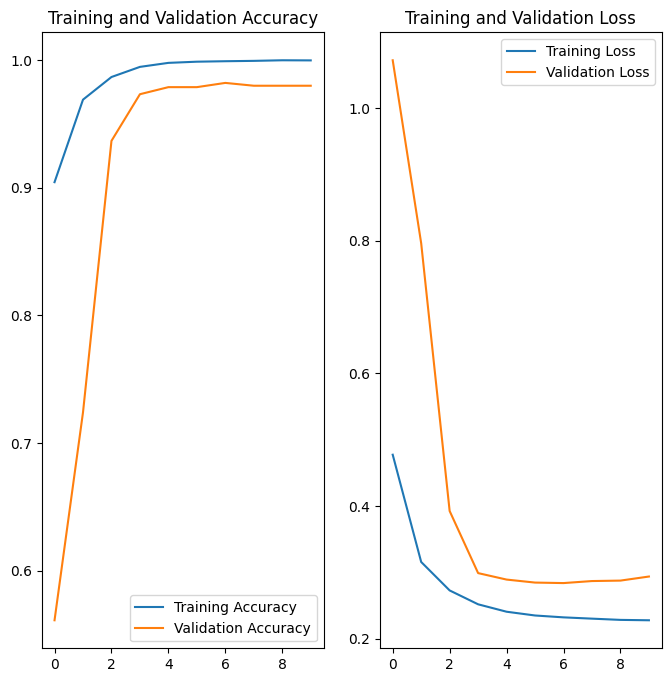

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = wmodel.predict(test_generator)

141/141 [==============================] - 7s 46ms/step


[[2523   44]
 [  70 1872]]


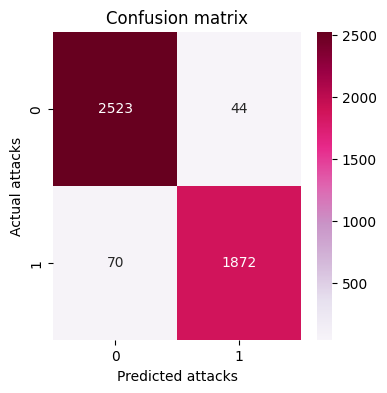

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2523   44]
 [  70 1872]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.97      0.98      0.98      2567
      normal       0.98      0.96      0.97      1942

    accuracy                           0.97      4509
   macro avg       0.98      0.97      0.97      4509
weighted avg       0.97      0.97      0.97      4509



# Transfer Learning using Imagenet (ILSVRC-2012-CLS) classification with ResNet V2 101.

In [ ]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow_hub as hub

hub_layer1 = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5",trainable=True)

zmodel = Sequential()
zmodel.add(hub_layer1)

# add two hidden layers for classification
zmodel.add(Dense(512, activation='relu'))
zmodel.add(Dense(256, activation='relu'))

# add the prediction layer
zmodel.add(Dense(1, activation=('sigmoid')))

zmodel.build([None, 224, 224, 3])  # Batch input shape.

zmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              44677609  
                                                                 
 dense_20 (Dense)            (None, 512)               513024    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 45322218 (172.89 MB)
Trainable params: 45224554 (172.52 MB)
Non-trainable params: 97664 (381.50 KB)
_________________________________________________________________


In [ ]:
import keras

zmodel.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = zmodel.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 233s 537ms/step - loss: 0.5170 - binary_accuracy: 0.9337 - val_loss: 0.4639 - val_binary_accuracy: 0.9634
Epoch 2/10
339/339 [==============================] - 180s 532ms/step - loss: 0.3932 - binary_accuracy: 0.9829 - val_loss: 0.4207 - val_binary_accuracy: 0.9745
Epoch 3/10
339/339 [==============================] - 181s 533ms/step - loss: 0.3672 - binary_accuracy: 0.9926 - val_loss: 0.4654 - val_binary_accuracy: 0.9634
Epoch 4/10
339/339 [==============================] - 181s 533ms/step - loss: 0.3577 - binary_accuracy: 0.9954 - val_loss: 0.4172 - val_binary_accuracy: 0.9745
Epoch 5/10
339/339 [==============================] - 181s 533ms/step - loss: 0.3564 - binary_accuracy: 0.9959 - val_loss: 0.4063 - val_binary_accuracy: 0.9767
Epoch 6/10
339/339 [==============================] - 181s 533ms/step - loss: 0.3548 - binary_accuracy: 0.9962 - val_loss: 0.4159 - val_binary_accuracy: 0.9778
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
zmodel.save("MODEL4-TL-NSL-KDD.keras")

In [ ]:
score = zmodel.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 4s 146ms/step - loss: 0.4368 - binary_accuracy: 0.9778
Test loss: 0.4368329346179962
Test accuracy: 0.9778270721435547


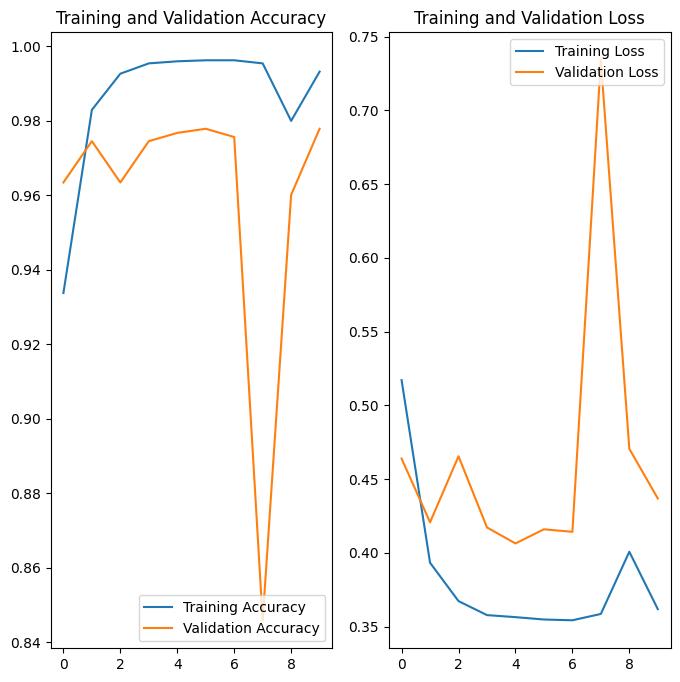

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = zmodel.predict(test_generator)

141/141 [==============================] - 22s 146ms/step


[[2525   42]
 [  66 1876]]


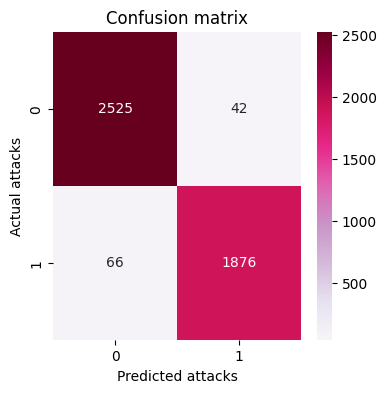

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2525   42]
 [  66 1876]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.97      0.98      0.98      2567
      normal       0.98      0.97      0.97      1942

    accuracy                           0.98      4509
   macro avg       0.98      0.97      0.98      4509
weighted avg       0.98      0.98      0.98      4509



# Transfer Learning using Pretrained-VGG16

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
newt_model = Sequential()
newt_model.add(Flatten(input_shape=base_model.output_shape[1:]))

# add two hidden layers for classification
newt_model.add(Dense(512, activation='relu'))
newt_model.add(Dense(256, activation='relu'))

# add the prediction layer
newt_model.add(Dense(1, activation=('sigmoid')))

newt_model = Model(inputs=base_model.input, outputs=newt_model(base_model.output))
newt_model.build([None, 224, 224, 3])  # Batch input shape.

newt_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import keras

newt_model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = newt_model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 147s 423ms/step - loss: 0.1544 - binary_accuracy: 0.9432 - val_loss: 0.0774 - val_binary_accuracy: 0.9745
Epoch 2/10
339/339 [==============================] - 143s 421ms/step - loss: 0.0864 - binary_accuracy: 0.9678 - val_loss: 0.0788 - val_binary_accuracy: 0.9701
Epoch 3/10
339/339 [==============================] - 143s 420ms/step - loss: 0.0629 - binary_accuracy: 0.9754 - val_loss: 0.0674 - val_binary_accuracy: 0.9778
Epoch 4/10
339/339 [==============================] - 143s 421ms/step - loss: 0.0495 - binary_accuracy: 0.9806 - val_loss: 0.0597 - val_binary_accuracy: 0.9778
Epoch 5/10
339/339 [==============================] - 143s 422ms/step - loss: 0.0407 - binary_accuracy: 0.9834 - val_loss: 0.0611 - val_binary_accuracy: 0.9767
Epoch 6/10
339/339 [==============================] - 143s 421ms/step - loss: 0.0365 - binary_accuracy: 0.9855 - val_loss: 0.0682 - val_binary_accuracy: 0.9767
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
newt_model.save("MODEL5-TL-NSL-KDD.keras")

In [ ]:
score = newt_model.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 3s 120ms/step - loss: 0.0546 - binary_accuracy: 0.9856
Test loss: 0.054568514227867126
Test accuracy: 0.9855875968933105


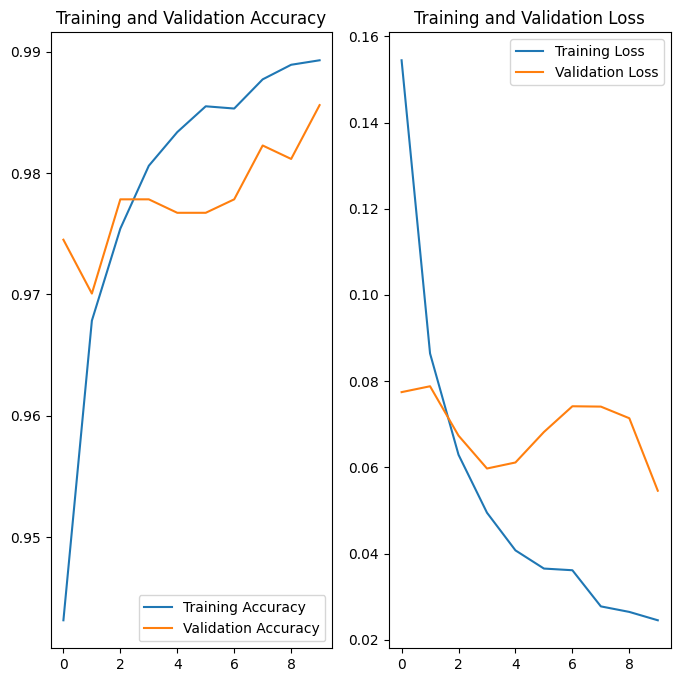

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = newt_model.predict(test_generator)

141/141 [==============================] - 17s 122ms/step


[[2504   63]
 [  45 1897]]


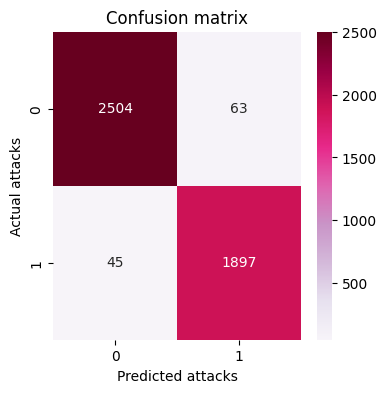

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2504   63]
 [  45 1897]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.98      0.98      0.98      2567
      normal       0.97      0.98      0.97      1942

    accuracy                           0.98      4509
   macro avg       0.98      0.98      0.98      4509
weighted avg       0.98      0.98      0.98      4509



# Transfer Learning using Pretrained-VGG19

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model1 = applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [ ]:
newty_model = Sequential()
newty_model.add(Flatten(input_shape=base_model1.output_shape[1:]))

# add two hidden layers for classification
newty_model.add(Dense(512, activation='relu'))
newty_model.add(Dense(256, activation='relu'))

# add the prediction layer
newty_model.add(Dense(1, activation=('sigmoid')))

newty_model = Model(inputs=base_model1.input, outputs=newty_model(base_model1.output))
newty_model.build([None, 224, 224, 3])  # Batch input shape.

newty_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import keras

newty_model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=2)
history = newty_model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 190s 514ms/step - loss: 0.1683 - binary_accuracy: 0.9369 - val_loss: 0.1057 - val_binary_accuracy: 0.9678
Epoch 2/10
339/339 [==============================] - 169s 500ms/step - loss: 0.0855 - binary_accuracy: 0.9675 - val_loss: 0.0763 - val_binary_accuracy: 0.9756
Epoch 3/10
339/339 [==============================] - 169s 500ms/step - loss: 0.0648 - binary_accuracy: 0.9760 - val_loss: 0.0626 - val_binary_accuracy: 0.9800
Epoch 4/10
339/339 [==============================] - 169s 500ms/step - loss: 0.0513 - binary_accuracy: 0.9800 - val_loss: 0.0580 - val_binary_accuracy: 0.9812
Epoch 5/10
339/339 [==============================] - 169s 499ms/step - loss: 0.0429 - binary_accuracy: 0.9835 - val_loss: 0.0592 - val_binary_accuracy: 0.9878
Epoch 6/10
339/339 [==============================] - 169s 499ms/step - loss: 0.0375 - binary_accuracy: 0.9849 - val_loss: 0.0643 - val_binary_accuracy: 0.9834
Epoch 7/10
339/339 [====================

In [ ]:
# lets save the model now
newty_model.save("MODEL6-TL-NSL-KDD.keras")

In [ ]:
score = newty_model.evaluate(val_ds, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 4s 148ms/step - loss: 0.0554 - binary_accuracy: 0.9823
Test loss: 0.05543720722198486
Test accuracy: 0.9822616577148438


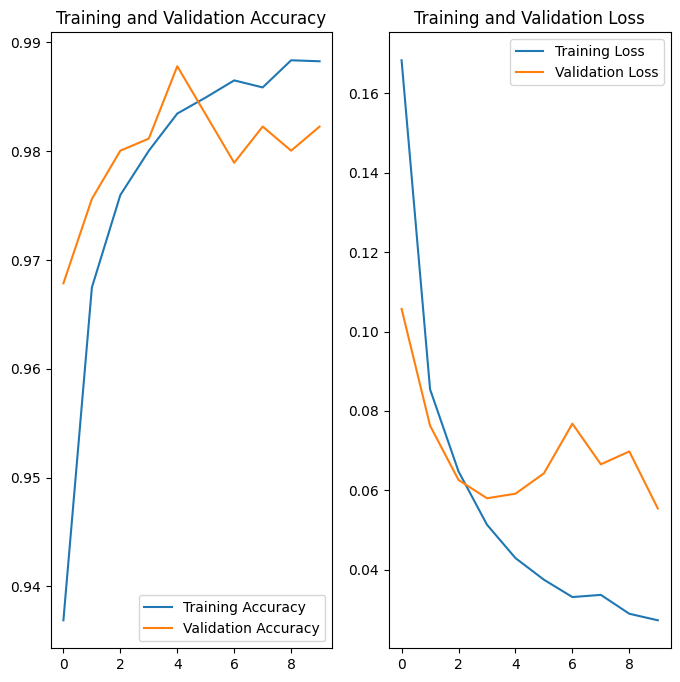

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = newty_model.predict(test_generator)

141/141 [==============================] - 26s 181ms/step


[[2521   46]
 [  52 1890]]


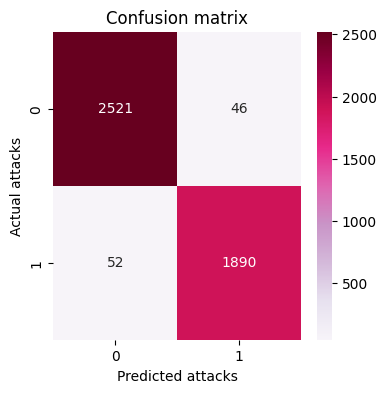

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2521   46]
 [  52 1890]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.98      0.98      0.98      2567
      normal       0.98      0.97      0.97      1942

    accuracy                           0.98      4509
   macro avg       0.98      0.98      0.98      4509
weighted avg       0.98      0.98      0.98      4509



# Deep Learning for comparison using Training DS

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=('sigmoid'))
])

In [ ]:
import keras
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(
  train_ds,
  batch_size=batchsize,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  #callbacks=callback
)

Epoch 1/10
339/339 [==============================] - 12s 29ms/step - loss: 0.6719 - binary_accuracy: 0.5696 - val_loss: 0.6639 - val_binary_accuracy: 0.5776
Epoch 2/10
339/339 [==============================] - 10s 29ms/step - loss: 0.6307 - binary_accuracy: 0.6568 - val_loss: 0.6116 - val_binary_accuracy: 0.7561
Epoch 3/10
339/339 [==============================] - 10s 29ms/step - loss: 0.5635 - binary_accuracy: 0.7539 - val_loss: 0.5495 - val_binary_accuracy: 0.7583
Epoch 4/10
339/339 [==============================] - 10s 29ms/step - loss: 0.5030 - binary_accuracy: 0.7849 - val_loss: 0.5080 - val_binary_accuracy: 0.7849
Epoch 5/10
339/339 [==============================] - 10s 28ms/step - loss: 0.4618 - binary_accuracy: 0.7975 - val_loss: 0.4685 - val_binary_accuracy: 0.7894
Epoch 6/10
339/339 [==============================] - 10s 28ms/step - loss: 0.4280 - binary_accuracy: 0.8142 - val_loss: 0.4548 - val_binary_accuracy: 0.7927
Epoch 7/10
339/339 [==============================] 

In [ ]:
# lets save the model now
model.save("MODEL0-TL-NSL-KDD.keras")

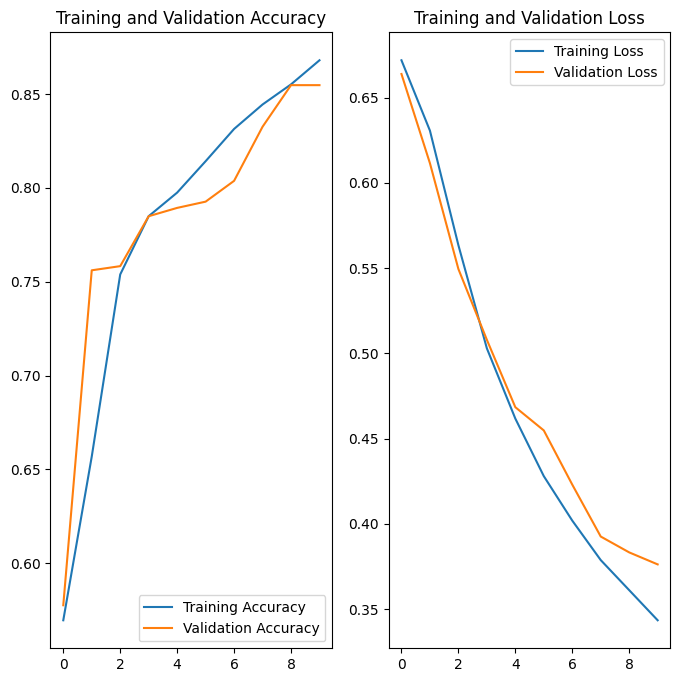

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# to get predictions for all test data points
Y_pred_res = model.predict(test_generator)

141/141 [==============================] - 7s 46ms/step


[[2403  164]
 [ 471 1471]]


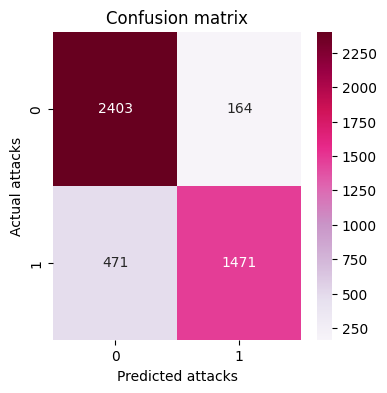

In [ ]:
conf_matrix_res = confusion_matrix(test_generator.classes, np.round(Y_pred_res))
print(conf_matrix_res)
# Display of the confusion matrix as a heatmap
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix_res, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted attacks')
plt.ylabel('Actual attacks')
plt.show()

In [ ]:
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['abnormal','normal']
class_rep_res = classification_report(test_generator.classes, np.round(Y_pred_res), target_names=target_names)
print(class_rep_res)

[[2403  164]
 [ 471 1471]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.84      0.94      0.88      2567
      normal       0.90      0.76      0.82      1942

    accuracy                           0.86      4509
   macro avg       0.87      0.85      0.85      4509
weighted avg       0.86      0.86      0.86      4509

